# ThisPokemonDoesNotExist

In [13]:
# install libs
! pip install pandas
! pip install numpy
! pip install matplotlib
! pip install tensorflow

## Download dataset

In [14]:
# ! git clone https://github.com/Zer0Nu11/ThisPokemonDoesNotExist.git
! wget https://github.com/Zer0Nu11/ThisPokemonDoesNotExist/raw/main/dataset/archive.zip -O archive.zip
! unzip -u archive.zip

--2022-10-19 13:52:56--  https://github.com/Zer0Nu11/ThisPokemonDoesNotExist/raw/main/dataset/archive.zip
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Zer0Nu11/ThisPokemonDoesNotExist/main/dataset/archive.zip [following]
--2022-10-19 13:52:57--  https://raw.githubusercontent.com/Zer0Nu11/ThisPokemonDoesNotExist/main/dataset/archive.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60660766 (58M) [application/zip]
Saving to: ‘archive.zip’

archive.zip         100%[===================>]  57.85M  --.-KB/s    in 0.1s    

2022-10-19 13:53:02 (419 MB/s) - ‘archive.zip’ saved [60660766/606607

## Imports

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
from zipfile import ZipFile


In [16]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Load dataset

In [17]:
import os
from PIL import Image

sizes = []
images = []

pokemons = os.listdir('images')
for i in pokemons:
  pics = os.listdir('images/'+i)
  for j in pics:
    path = 'images/'+i+'/'+j
    im = Image.open(path)
    sizes.append(im.size)
    images.append(im)

In [18]:
unique = list(set(sizes))
len(unique)

811

pictures have different sizes, so we need to crop them

In [19]:
unique.sort(key=lambda x: abs(x[0]-x[1]), reverse=True)
unique[:10]

[(146, 400),
 (360, 113),
 (360, 131),
 (360, 134),
 (177, 400),
 (360, 138),
 (180, 400),
 (360, 143),
 (190, 400),
 (191, 400)]

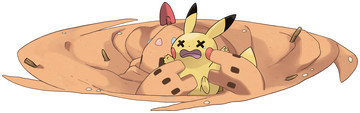

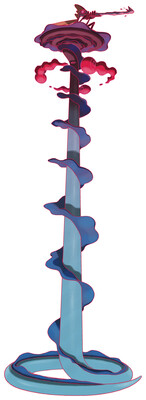

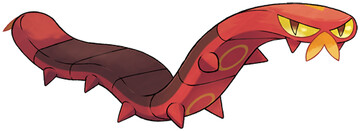

In [20]:
ind = 0
for im in images:
  if im.size in unique[:3]:
    display(im)

In [22]:
dataset = keras.preprocessing.image_dataset_from_directory(
    "images", label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)

Found 2503 files belonging to 1 classes.


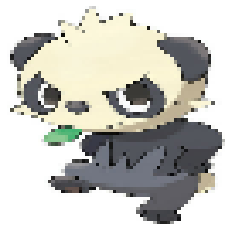

In [23]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

## Model

In [24]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

In [25]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0 

In [26]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

## Callback

In [27]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated/generated_img_%03d_%d.png" % (epoch, i))

## Train

In [ ]:
epochs = 100  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)]
)

Epoch 1/100
79/79 [==============================] - 25s 292ms/step - d_loss: 0.9403 - g_loss: 0.9372
Epoch 2/100
79/79 [==============================] - 22s 281ms/step - d_loss: 0.5415 - g_loss: 1.2533
Epoch 3/100
79/79 [==============================] - 22s 275ms/step - d_loss: 0.5921 - g_loss: 1.3907
Epoch 4/100
79/79 [==============================] - 22s 277ms/step - d_loss: 0.4829 - g_loss: 1.7927
Epoch 5/100
79/79 [==============================] - 22s 279ms/step - d_loss: 0.5682 - g_loss: 1.1279
Epoch 6/100
79/79 [==============================] - 23s 285ms/step - d_loss: 0.4735 - g_loss: 1.4746
Epoch 7/100
79/79 [==============================] - 22s 278ms/step - d_loss: 0.5147 - g_loss: 1.4082
Epoch 8/100
79/79 [==============================] - 22s 276ms/step - d_loss: 0.7258 - g_loss: 1.0958
Epoch 9/100
79/79 [==============================] - 23s 287ms/step - d_loss: 0.5937 - g_loss: 1.5175
Epoch 10/100
79/79 [==============================] - 22s 280ms/step - d_loss: 0.5